# Assignment 2

Loading and cleaning data

In [158]:
# Scientific and vector computation for python
import numpy as np

# Data Manipulation Library
import pandas as pd

# Plotting library
from matplotlib import pyplot

# inline graphs
%matplotlib inline

# Optimization module in scipy
from scipy import optimize

# import KFold library for splitting dataset
from sklearn.model_selection import KFold

# data url
github_url = 'https://raw.githubusercontent.com/RohanK99/machine-learning/master/CS480/A1/knn-dataset/'

In [206]:
# read training data
training_data = []
training_labels = []
for i in range(10):
    # training data
    url = github_url + 'trainData{}.csv'.format(i+1)
    data = pd.read_csv(url, header=None)
    training_data.append(data)
    # training labels
    url = github_url + 'trainLabels{}.csv'.format(i+1)
    data = pd.read_csv(url, header=None)
    training_labels.append(data)

# concatenate data into 1 large data set and convert to numpy
X = (pd.concat(training_data)).to_numpy()
X = np.c_[np.ones(X.shape[0]), X] # add column of ones
y = ((pd.concat(training_labels)).to_numpy())[:,0] # first column

In [207]:
# read test data
data_url = github_url + 'testData.csv'
label_url = github_url + 'testLabels.csv'
data = pd.read_csv(data_url, header=None)
t_X = data.to_numpy()
t_X = np.c_[np.ones(t_X.shape[0]), t_X] # add column of ones
labels = pd.read_csv(label_url, header=None)
t_y = labels.to_numpy()[:,0]

## Question 1
### a) 
Mixture of Gaussians: let $\pi = P(y = C_1)$ and $1 - \pi=P(y = C_2)$. Let $P(x|C_1)=N(x|\mu_1, \Sigma)$ and $P(x|C_2) = N(x|\mu_2, \Sigma)$. Learn the parameters $\pi$, $\mu_1$, $\mu_2$ and $\Sigma$ by likelihood maximization. Use Bayes theorem to compute the probability of each class given an input $x: P(C_j|x) = k P(C_j) P(x|C_j)$.

We can express the Likelihood of our training set as $L(X,y) = P(X,y|\pi,\mu_1,\mu_2,\Sigma)$. We want to maximize the likelihood in order to use Bayes inference.
$$
\begin{align*}
L(X,y) &= \prod_{n}{[\pi|\mu_1, \Sigma]^{y_n}[(1-\pi)|N(x_n|\mu_2,\Sigma)]^{1-y_n}}\\
\end{align*}
$$
Taking the log we can turn this into an optimization problem of finding
$$
\begin{align*}
&= argmax_{\pi, \mu_1, \mu_2, \Sigma} \sum _{n}{y_n[ln\pi - \frac{1}{2}(x_n - \mu_1)^T \Sigma^{-1}(x_n-\mu_1)]+(1-y_n)[ln\pi - \frac{1}{2}(x_n - \mu_2)^T \Sigma^{-1}(x_n-\mu_2)]}\\
\end{align*}
$$

In [167]:
# Define classes
c_1 = y == 5
c_2 = y == 6

Now to estimate $\pi$ (probability of class) we can take:
$$
\begin{align*}
0 &= \frac{\partial lnL(X,y)}{\partial \pi} \\
\pi &= \frac{\sum_n{y_n}}{N} \\
\end{align*}
$$


In [233]:
pi = np.count_nonzero(c_1)/y.shape[0]
print("pi is: " + str(pi))

pi is: 0.5


Now to estimate $\mu_1$ and $\mu_2$ (mean of classes) we can take:
$$
\begin{align*}
0 &= \frac{\partial lnL(X,y)}{\partial \mu_1} \\
\mu_1 &= \frac{\sum_n{y_n}{x_n}}{N_1} \\
\end{align*}
$$

and 

$$
\begin{align*}
0 &= \frac{\partial lnL(X,y)}{\partial \mu_2} \\
\mu_2 &= \frac{\sum_n{(1-y_n)}{x_n}}{N_2} \\
\end{align*}
$$

In [234]:
mu_1 = np.mean(X[c_1], axis=0)
mu_2 = np.mean(X[c_2], axis=0)
print("mu_1 is: " + str(mu_1))
print("mu_2 is: " + str(mu_2))

mu_1 is: [ 1.     4.846  4.902  8.28   9.858 10.68   9.342  6.198  4.602  4.978
  5.998 10.498  9.662  8.448  7.66   5.322  4.412  4.438  6.36  10.02
  6.84   5.6    4.764  4.436  4.366  4.758  6.392 10.126  9.514  7.924
  6.302  4.532  4.64   4.812  5.274  7.596  7.948  8.518  7.668  5.634
  4.226  4.612  4.718  4.924  5.762  7.362  8.612  5.764  4.408  4.29
  5.038  7.032  7.762  8.782  7.908  5.516  4.548  4.456  4.758  8.606
 10.226  8.702  6.198  5.002  4.944]
mu_2 is: [ 1.     5.158  4.954  5.654  9.55   8.618  5.482  5.478  4.896  4.782
  4.75   8.194 10.272  7.03   5.272  4.864  4.736  4.864  5.058  9.814
  8.438  4.92   5.068  4.762  4.882  4.686  5.76  10.572  8.02   6.306
  5.47   5.154  4.664  4.988  6.278 10.67   9.814  9.532  8.804  5.84
  4.588  4.832  5.732 10.402  9.132  7.756  9.324  8.338  4.732  4.704
  5.334  9.224  9.968  7.304  9.668  8.934  4.968  4.932  5.002  5.84
  9.202 10.99   9.72   6.41   5.186]


Now to estimate $\Sigma$ (covariance matrix) we can take:
$$
\begin{align*}
0 &= \frac{\partial lnL(X,y)}{\partial \Sigma} \\
\Sigma &= \frac{N_1}{N}S_1 + \frac{N_2}{N}S_2\\
\end{align*}
$$
where $S_k$ are the empirival covariance matrices of the class k
$$
\begin{align*}
S_1 &= \frac{1}{N_1}\sum _{n\in C_1}{(x_n-\mu_1)(x_n-\mu_1)^T}\\
S_2 &= \frac{1}{N_1}\sum _{n\in C_2}{(x_n-\mu_2)(x_n-\mu_2)^T}\\
\end{align*}
$$

In [235]:
s_1 = np.cov(X[c_1], rowvar=False)
s_2 = np.cov(X[c_2], rowvar=False)
sigma = X[c_1].shape[0]/y.shape[0] * s_1 + X[c_2].shape[0]/y.shape[0] * s_2
print("sigma is: ")
print(sigma)

sigma is: 
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.         40.14995992 22.0321523  ... 23.16269138 24.42160721
  26.52504409]
 [ 0.         22.0321523  39.90194389 ... 27.27681563 26.486501
  26.6588517 ]
 ...
 [ 0.         23.16269138 27.27681563 ... 44.08637074 27.76873948
  23.90038477]
 [ 0.         24.42160721 26.486501   ... 27.76873948 42.75746293
  26.02096794]
 [ 0.         26.52504409 26.6588517  ... 23.90038477 26.02096794
  40.16045491]]


Now we need to create the bayes inference function to predict the classification. We know that bayes formula is:

\begin{align*}
P(C_j|x) &= \frac{P(C_j) P(x|C_j)}{\sum_c P(x|C_j)P(C_j)}\\
&= kP(C_j) P(x|C_j)
\end{align*}

Now assuming Gaussian distribution and that the same covariance matrix $\Sigma$ is used for each class then:

\begin{align*}
P(x|C_j) \propto e^{-\frac{1}{2}(x-\mu_k)^T \Sigma^{-1}(x-\mu_k)}
\end{align*}

Subbing our assumptions to get the posterior distribution we get the logistic sigmoid function.

\begin{align*}
P(C_j|x) = \frac{1}{1 + e^{-(w^Tx+w_o)}}
\end{align*}

where

\begin{align*}
w &= \Sigma^{-1}(\mu_j - \mu_k)\\
w_o &= -\frac{1}{2}\mu_j^T \Sigma^{-1}\mu_j + \frac{1}{2}\mu_k^T \Sigma^{-1}\mu_k + ln\frac{\pi_1}{\pi_2}
\end{align*}

In [5]:
def sigmoid(z):
    # convert input to a numpy array
    z = np.array(z)
    
    # compute sigmoid
    g = np.zeros(z.shape)
    g = 1.0 / (1 + np.exp(-z))
    return g

In [237]:
sigma_inv = np.linalg.pinv(sigma)
w = sigma_inv@(mu_1 - mu_2)
w_o = -1/2*mu_1.T@sigma_inv@mu_1 + 1/2*mu_2.T@sigma_inv@mu_2 + np.log(pi/(1-pi))
print(w_o)
print(w)

0.09843704514833984
[ 0.         -0.01540531  0.01616244  0.03929692 -0.00456321  0.06182967
  0.15334141  0.01915415  0.05507069  0.08670551 -0.01681262  0.1203822
  0.00441396  0.02588328  0.15001922 -0.00107855 -0.04174986  0.07194328
  0.04522785  0.01061901 -0.02694246 -0.00675116 -0.05810351 -0.04177076
  0.02758435  0.08169968  0.0226441  -0.02123403  0.01795245  0.09192023
 -0.00836835 -0.07566645 -0.0045614   0.08674114 -0.01242315 -0.06059901
 -0.03379977 -0.02829977 -0.08825168 -0.04110495 -0.03506517 -0.02520544
  0.00681327 -0.21247372 -0.07226558 -0.00982123  0.03154254  0.02651147
 -0.05090439  0.02273982 -0.09561958 -0.07537277 -0.04687759  0.06141118
 -0.03530406 -0.06769001 -0.00184102 -0.04228458 -0.07332246  0.08705653
  0.05281176 -0.00978789 -0.05968752 -0.0054356   0.00299748]


In [255]:
prediction = sigmoid(t_X@w + w_o) >= 0.5 # prediction 5
actual = t_y == 5
print("accuracy: {:.1f}%".format(np.sum(prediction == actual)/t_y.shape[0]*100))

accuracy: 89.1%


### b)
Logistic regression: let $P(C_1|x) = \sigma(w^T x+w_0)$ and $P(C_2|x) = 1-\sigma(w^T x+w_0)$. Learn the
parameters $w$ and $w_0$ by conditional likelihood maximization. More specifically use Newton’s algorithm
derived in class to optimize the parameters. 10 iterations of Newton’s algorithm should be sufficient for
convergence. Add a penalty of $0.5\lambda||w||^2_2$
to regularize the weights. Find the optimal hyperparameter \lambda
by 10-fold cross-validation

We will use discriminative learning to directly try and model $P(C_j|x)$ directly. We know the generic form of $P(C_j|x)$ is the logistic sigmoid (binary classification) or softmax (general classification). Now we can express the equation for solving for the weights as such.

\begin{align*}
w^* = argmax_w \prod_{n}{\sigma(w^T\overline{x_n})^{y_n}(1-\sigma(w^T\overline{x_n}))^{1-y_n}}
\end{align*}

Now taking the negative log likelihood we can pose the problem as an minima optimization problem with loss function:

\begin{align*}
L(w) = \sum_n{y_nln\sigma(w^T\overline{x_n}) + (1-y_n)ln(1-\sigma(w^T\overline{x_n}))}
\end{align*}

Due to potential of overfitting we want to regularize the loss function as such:

\begin{align*}
L(w) = \sum_n{y_nln\sigma(w^T\overline{x_n}) + (1-y_n)ln(1-\sigma(w^T\overline{x_n}))} + \frac{\lambda}{2}||w||^2_2
\end{align*}

Now we use an iterative method to solve for the weights $w$ since we can not find a closed form solution to the minimization problem.



In [208]:
def costFunctionReg(w, X, y, lambda_):
    m = y.size  # number of training examples

    J = 0 #
    grad = np.zeros(w.shape)

    # cost function
    z = X @ w
    hyp = sigmoid(z)
    J = 1/m * (-np.transpose(y)@np.log(hyp) - np.transpose(1-y)@np.log(1-hyp)) + lambda_/(2*m)*np.square(np.linalg.norm(w[1:]))
    
    # gradient
    G = lambda_/m*w
    G[0] = 0
    grad = 1/m * np.transpose(X)@(hyp - y)+G

    return J, grad

In [209]:
# newton's method for iteratively calculating weights
options = {'maxiter': 10}

def newtons_method(X, y, lambda_):
    # make y binary
    y = (y == 6).astype(int) # 6 = 1 and 5 = 0

    initial_w = np.zeros(X.shape[1])
    res = optimize.minimize(costFunctionReg,
                        initial_w,
                        (X, y, lambda_),
                        jac=True,
                        method='TNC',
                        options=options)

    return res.x

Now to predict know that $P(C_j|x) = \sigma(w^Tx)$ so we can classifiy based on the probability threshold of 0.5. If $\sigma(w^Tx) >= 0.5$ then we can classify as a 6 otherwise 5. We can then create a helper function to score the accuracy of our prediction with the test set.

In [210]:
def predict(X, w):
    return (sigmoid(X@w) >= 0.5)

In [211]:
def score(X, y, w):
    prediction = predict(X, w)
    actual = (y == 6).astype(int)
    return np.sum(prediction == actual)/y.shape[0]*100

To find the best hyperparameter lambda we can use K-Fold Cross Validation and graph the accuracy of our parameters.

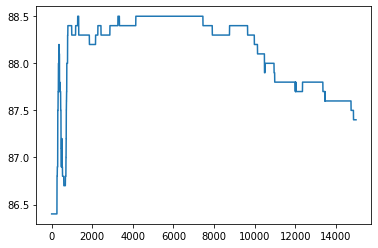

In [212]:
kf = KFold(n_splits=10)
max_lambda = 15000

accuracy = [0] * max_lambda
for lambda_ in range(0, max_lambda):
    for train, test in kf.split(X):
        X_train = X[train]
        y_train = y[train]

        w = newtons_method(X_train, y_train, lambda_)

        accuracy[lambda_] += score(X[test], y[test], w)
    accuracy[lambda_] /= 10

pyplot.plot(range(0, max_lambda), accuracy, '-')

From the graph we can see that we reach the highest accuracy at a lambda between 5500-7500, so we select lambda as 6500 and find our new weights and validate our score against the test dataset.

In [205]:
# test against test set
lambda_ = 6500 # from graph
w = newtons_method(X, y, lambda_)
accuracy = score(t_X, t_y, w)
print("accuracy: {:.1f}%".format(accuracy))

accuracy: 90.0%


# Question 2
a) Consider a threshold perceptron that predicts $y = 1$ when $w^Tx + w_0 \geq 0$ and $y = 0$ when
$w^Tx + w_0 \lt 0$. It is interesting to study the class of Boolean functions that can be represented by a
threshold perceptron. Assume that the input space is $X = \{0, 1\}^2$ and the output space is $Y = \{0, 1\}$.
For each of the following Boolean functions, indicate whether it is possible to encode the function as a
threshold perceptron. If it is possible, indicate some values for $w$ and $w_0$. If it is not possible, indicate a
feature mapping $\phi : X \rightarrow \hat{X}$ restricted to the space of polynomial mappings with values for $w$ and $w_0$
such that $w^T \phi(x) + w_0$ is a linear separator that encodes the function

If we satisify the following equation with weights such that for each of the logical operators it satisfies the output of $y = 1$ when $w^Tx + w_0 \geq 0$ and $y = 0$ when $w^Tx + w_0 \lt 0$ then there exists a linear separator. 

\begin{align}
\begin{bmatrix}
1 & x_1 & x_2
\end{bmatrix}
\begin{bmatrix}
w_0 \\
w_1 \\
w_2 \\
\end{bmatrix}
\end{align}

i) AND: Linearly separable, $w = \begin{pmatrix}1 \\ 1 \\ \end{pmatrix}$, $w_0 = -1.5$


ii) OR: Linearly separable, $w = \begin{pmatrix}1 \\ 1 \\ \end{pmatrix}$, $w_0 = -0.5$


iii) XOR: Not Linearly separable, use $\phi(x) = \begin{pmatrix}x_1 \\ x_2 \\ x_1 x_2\\ \end{pmatrix}$ with $w = \begin{pmatrix}1 \\1 \\ -2\\ \end{pmatrix}$ and $w_0 = -0.5$

iv) IFF: not linearly separable. Use $\phi(x) = \begin{pmatrix}x_1 \\ x_2 \\ x_1 x_2\\ \end{pmatrix}$ with $w = \begin{pmatrix}-1 \\-1 \\ 2\\ \end{pmatrix}$ and $w_0 = 0.5$


b) No, if the data set was linearly separable then the logistic regression technique would've found a separator with 100% training accuracy.